In [69]:
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.integrate import odeint
from scipy.signal import argrelextrema
import numdifftools as nd

In [106]:
#class for a single molecule species
class Species:
    # initialize species, make it aware of parent reaction system
    def __init__(self, system, name, constant=False):
        # system of the species 
        self.system = system
        self.name = name
        self.constant = constant
        
        # equation which describes the first time derivative of the species 
        self.equation = "0"
        # components of the different reactions, which constitute the time derivative
        self.components = ["0"]
        # function dt(X,P) which returns the calculated gradient
        self.dt = None
        
        self.generateFunction()
        
    # generate time derivative from components
    def generateFunction(self):
        self.equation = 'lambda X, P: ' + " + ".join(self.components)
        self.dt = eval(self.equation)
        
class Run: 
    def __init__(self,t,solution, model):
        self.time = t
        self.solution = solution
        self.model = model
        
    def plot(self, *args):
        for i, species in enumerate(self.model.species):
            if len(args)>0:
                if species.name in args[0]:
                    plt.plot(self.time,self.solution[:,i],label=species.name)         
            else:
                plt.plot(self.time,self.solution[:,i],label=species.name)
        fig = plt.gcf()
        fig.set_size_inches(15, 5)
        plt.legend()
        plt.show()
        
    def analyzeStability(self):
        jacobianF = nd.Jacobian(model.dX)
        jacobian = jacobianF(self.solution[-1,:],self.time[-1],np.array(self.model.parameters))
        print("===== STABILITY ANALYSIS =====\nThe stability analysis is only valid for steady states. \n")
        print("Jacobian at time={} ".format(self.time[-1]) )
        print(jacobian)
        eig_values, eig_vectors = np.linalg.eig(jacobian)
        print("\n")
        print("Eigen values")
        print(eig_values)
        print("\n")
        print("Eigen vectors")
        print(eig_vectors)
        print("\n")
        
        negReal = np.where(eig_values < 0)[0]
        zero = np.where(eig_values == 0)
        
        print(len(negReal),len(eig_values))
        
        if len(negReal) == len(eig_values):
            print("All eigenvalues have negative real parts, \nthe steady state is asymptotically stable")
        else:
            print("Not all eigenvalues have negative real parts, \nthe steady state is unstable") 
            
        return len(negReal) == len(eig_values)
        
class Model:
    def __init__(self):
        self.species = []
        self.parameters = []
        self.reactions = []
        self.loaded = False
        
    def getSpecies(self, name):
        for i, s in enumerate(self.species):
            if s.name == name:
                return s
        print("getSpecies error: species " + name + " was not found")
        return None
    
    def indexSpecies(self, name):
        for i, s in enumerate(self.species):
            if s.name == name:
                return i
        print("indexSpecies error: species " + name + " was not found")
        return None
        
    def addSpecies(self, name, *args, **kwargs):
        self.species.append(Species(self, name, *args, **kwargs))
        
    def addReaction(self, reactants, stoichometry, k, kinetic_dependencies, reaction_id, reaction_comment):
        
        reaction = {
            "id": reaction_id, 
            "type": "stoichometric", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": kinetic_dependencies,
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "k"})
        self.parameters.append(k[0])
        
        self.reactions.append(reaction)
        
        parameter = "P[{}]".format(len(self.parameters)-1)
        
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies]
        order = len(kinetic_dependencies)
        
        nth = " * " if order > 0 else ""
        v = parameter + nth +  "*".join(species)
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
            
    def addMichaelisKinetics(self, reactants, stoichometry, k,kinetic_dependencies, reaction_id, reaction_comment):
        
        reaction = {
            "id": reaction_id, 
            "type": "Michaelis Menten kinetics", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": [],
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "V_max"})
        self.parameters.append(k[0])
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_m"})
        self.parameters.append(k[1]) #K_m
        
        self.reactions.append(reaction)
        
        V_max = "P[{}]".format(len(self.parameters)-2)
        K_m = "P[{}]".format(len(self.parameters)-1)
        
        limiting_substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies]
        nth = " * " if len(kinetic_dependencies) > 0 else ""               
        
        v = V_max + nth +  "*".join(species) + " * " + limiting_substrate + " /(" + K_m + " + " +  limiting_substrate + ")"
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
        
    def addHillKinetics(self, reactants, stoichometry, k, reaction_id, reaction_comment):
        reaction = {
            "id": reaction_id, 
            "type": "hill-enzyme-kinetic", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": [],
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "V_max"})
        V_max = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[0]) #hill_coefficent
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_a"})
        K_a = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[1]) #K_a
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "hill coefficient"})
        hill_coefficent = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[2]) #k_cat
        
        self.reactions.append(reaction)
        
        
        substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies]
        nth = " * " if len(kinetic_dependencies) > 0 else ""
        
        v = V_max + nth +  "*".join(species) + " *(" + substrate + "**" +  hill_coefficent + ")/(" + K_a + "**" + hill_coefficent + " + "+ substrate + "**" +  hill_coefficent + ")"
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
            
    def addInhibitonKinetics(self, reactants, stoichometry, k, kinetic_dependencies, reaction_id, reaction_comment):
        reaction = {
            "id": reaction_id, 
            "type": "Michaelis Menten kinetic with noncompetetive inhibition", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": kinetic_dependencies,
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "V_max"})
        V_max = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[0]) 
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_m"})
        K_m = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[1]) 
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_i"})
        K_i = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[2]) 
        
        self.reactions.append(reaction)
        
        inhibitor = "X[{}]".format(self.indexSpecies(kinetic_dependencies[0]))
        substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies[1:]]
        nth = " * " if len(kinetic_dependencies) > 1 else ""
        
        v = V_max + nth +  "*".join(species) + " * " + substrate + " /((" + K_m + " + " +  substrate + ")"
        v += " *(1+" + inhibitor +"/"+ K_i +"))" 
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
            
    def addActivationKinetics(self, reactants, stoichometry, k, kinetic_dependencies, reaction_id, reaction_comment):
        reaction = {
            "id": reaction_id, 
            "type": "Michaelis Menten kinetic with allosteric activation", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": kinetic_dependencies,
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "V_max"})
        V_max = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[0]) #k_cat
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_m"})
        K_m = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[1]) #K_m
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_a"})
        K_a = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[2]) #K_i
        
        self.reactions.append(reaction)
        
        activator = "X[{}]".format(self.indexSpecies(kinetic_dependencies[0]))
        substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies[1:]]
        nth = " * " if len(kinetic_dependencies) > 1 else ""
        
        v = V_max + nth +  "*".join(species) + " * " + substrate +"*" + activator +" /((" + K_m  + "+" +substrate+" )*( "+ K_a + "+" + activator+ "))"
    
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
        
    def dX(self, X,t, P):
        dX = np.array([species.dt(X,P) for species in self.species])
        return dX
    
    def load(self, path):
        if self.loaded:
            print("warning: model will be overwritten")
            self.species = []
            self.parameters = []
                  
        with open (path, "r") as myfile:
            data=myfile.readlines()
    
        reaction_id = 0
        # read model from system definition
        for i, line in enumerate(data):
            #remove newline and spaces
            line = line.strip("\n")
            


            # match first line for species definition
            if i == 0:
                species_match = re.findall('\$?[A-Z]+', line)
                if species_match:
                    for species in species_match:
                        if species[0] == "$":
                            self.addSpecies(species[1:], constant=True)
                        else:
                            self.addSpecies(species)
                else:
                    print("error: no species found in first line of system definition")

            #match consecutive lines for reaction equations
            else:
                if len(line) > 0 and line[0] != "#":
                    
                                   
                    reaction_match = re.findall(r"(.+)?-([A-Z])-(.*)->([0-9A-Z+ ]+)?(?:#(.*))?$",line)
                   
                    
                    if len(reaction_match) > 0:
                        reaction_id += 1
                        
                        educts = reaction_match[0][0]
                        reaction_type = reaction_match[0][1]
                        reaction_constants = reaction_match[0][2]
                        products = reaction_match[0][3]
                        
                        reaction_comment = reaction_match[0][4] 
                        
                        
                        
                        #match reaction constants and dependencies
                        constants = re.findall("(\d*\.?\d+)", reaction_constants)

                        if(len(constants) > 0):
                            constants = [float(i) for i in constants]
                            kinetic_dependencies = re.findall('[0-9]*[A-Z]+', reaction_constants)
                            reaction_order = len(kinetic_dependencies)

                        else: 
                             print("error: reaction constant was missing")

                        #match products and educts
                        educt_species = re.findall('[0-9]*[A-Z]+', educts)
                        product_species = re.findall('[0-9]*[A-Z]+', products)
                    
                        reactants = []
                        stoichometry = []

                        for educt in educt_species:

                            s = re.findall('[0-9]+', educt)
                            N = 1 if len(s) == 0 else int(s[0])
                            name = re.findall('[A-Z]+', educt)[0]

                            if name in reactants:
                                stoichometry[reactants.index(name)] -= N
                            else:
                                reactants.append(name)
                                stoichometry.append(-N)

                        for product in product_species:

                            s = re.findall('[0-9]+', product)
                            N = 1 if len(s) == 0 else int(s[0])
                            name = re.findall('[A-Z]+', product)[0]

                            if name in reactants:
                                stoichometry[reactants.index(name)] += N
                            else:
                                reactants.append(name)
                                stoichometry.append(N)

                        #stoichometric reaction        
                        if reaction_type == "S":

                            self.addReaction(reactants,stoichometry,constants, reactants[:len(educt_species)], reaction_id, reaction_comment)      

                        #reaction with michaelis menten kinetics
                        if reaction_type == "M":

                            if len(educt_species) > 1:
                                print("warning: michaelis menten kinetics with more than one substrate specified. species " + educt_species[0] +" will be choosen as rate limiting.")

                            self.addMichaelisKinetics(reactants,stoichometry,constants,kinetic_dependencies, reaction_id, reaction_comment)      
                            print(constants,kinetic_dependencies)
                            
                        #reaction with hill kinetics
                        if reaction_type == "H":
                            if len(educt_species) > 1:
                                print("warning: hill kinetic with more than one substrate specified. species " + educt_species[0] +" will be choosen as rate limiting.")
                                
                            self.addHillKinetics(reactants,stoichometry,constants,kinetic_dependencies, reaction_id, reaction_comment)
                            
                            print(reactants,stoichometry,constants,kinetic_dependencies)
                        
                        #michaelis menten kinetics with allosteric inhibition
                        if reaction_type == "I":
                            if len(educt_species) > 1:
                                print("warning: inhibitory kinetic with more than one substrate specified. species " + educt_species[0] +" will be choosen as rate limiting.")
                                
                            self.addInhibitonKinetics(reactants,stoichometry,constants,kinetic_dependencies, reaction_id, reaction_comment)
                            
                        #michaelis menten kinetics with allosteric activation
                        if reaction_type == "A":
                           
                                
                            self.addActivationKinetics(reactants,stoichometry,constants,kinetic_dependencies, reaction_id, reaction_comment)
        
    #move to simulation run class
    def simulate(self,X0,duration):
        t = np.linspace(0,duration,2000)
        solution = odeint(self.dX,X0,t,args=(model.parameters,))
        
        
        return(Run(t,solution,self))
    
    def explain(self):
        print("===== ODE Kinetic model  =====\n")
        print("the following species were defined: \n")
        
        for species in self.species:
            print("{:<8}".format(species.name))
            
                
        
        print("\nthe following reactions were defined:")
        
        for reaction in self.reactions:
            print("\n{}: ".format(reaction["id"]) + reaction["type"])
            print(reaction["description"])
            print("reaction partner :" + ", ".join(reaction["reactants"]))
            print("stoichometry     :" + ", ".join(str(x) for x in reaction["stoichometry"]))
            print("dependency       :" + ", ".join(reaction["kinetic_dependencies"]))
            print("parameters       :")
            
            for parameter in reaction["parameters"]:
                print("   {:<6}".format(parameter["name"]) + ": {}".format(self.parameters[parameter["id"]]))
        
    

[1.0, 2.0] []


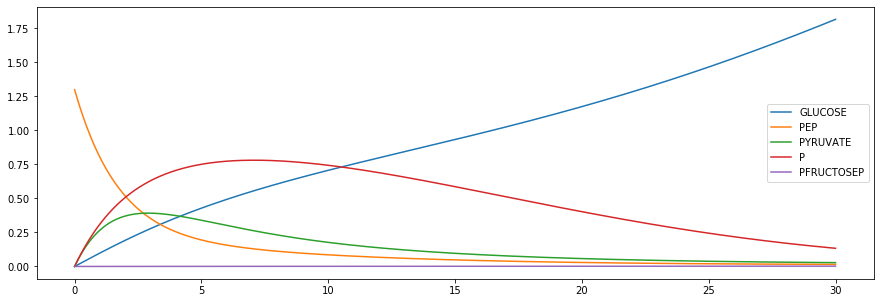

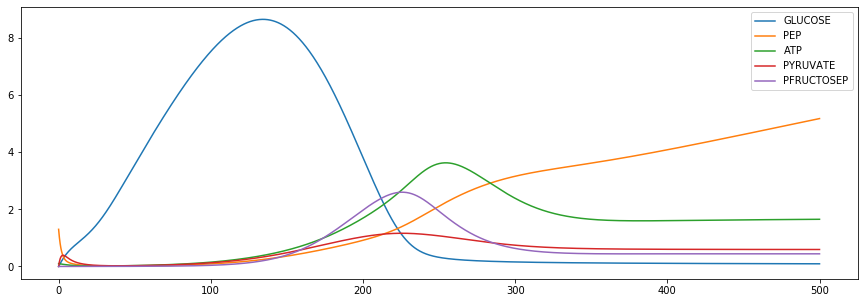

In [107]:
model = Model()
model.load("glycolisis.txt")
#model.explain()

index = model.reactions[0]["parameters"][0]["id"]



X0 = [0,1.3, 0.1, 0, 0,0,0,0,0,0,0,0]

initial = model.simulate(X0,30)
initial.plot(["GLUCOSE","PEP", "PYRUVATE","PFRUCTOSEP","P"])
run = model.simulate(X0,500)
run.plot(["GLUCOSE","PEP", "PYRUVATE","ATP","PFRUCTOSEP"])


### Computational Systems biology 2020
#### Assignment 2: Detailed analysis of small-scale dynamical systems

##### 1. Scope of the Project
##### 2. Overview of functionality
##### 2.1 Species

##### 2.2 Reactions
###### 2.2.1 Stoichometric reactions

$$
2A + B \rightarrow 2C + D
$$
Of the general Form:
$$
n_A A + n_B B + \ldots  \rightarrow n_C C + n_D D + \ldots\\
v = k[A]^{n_A} [B]^{n_B} \ldots
$$
For educts:
$$
\frac{dA}{dt} = - v n_A [A]
$$
For products:
$$
\frac{dC}{dt} = v n_C [C]
$$
*example_01.txt:*
```
A, B, C, D
# EDUKT + EDUKT -S-{k}-> PRODUCT + PRODUCT # Comment or reaction description

# 0 order inflow
-S-1-> A
-S-0.75-> B

# 3rd order reaction kinetics
2A + B -S-0.5-> 2C + D # Reaction of two A and one B, k=0.5

# 1st order outflow

B -S-0.2->
C -S-0.3-> 
D -S-0.5->
```

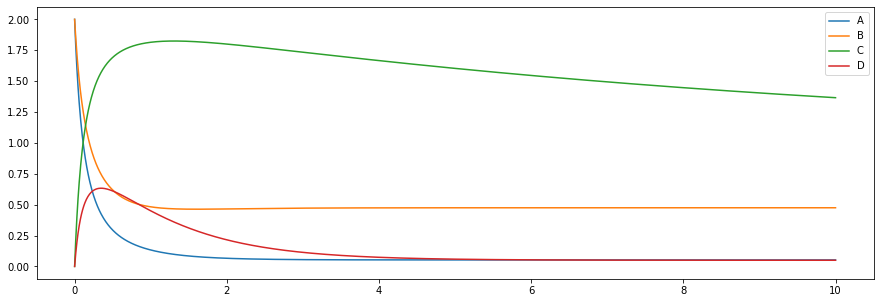

In [109]:
example_01 = Model()
example_01.load("example_01.txt")

X0 = [2,2,0,0]
run = example_01.simulate(X0,10)
run.plot()


###### 2.2.2 Michaelis Menten kinetics
###### 2.2.3 Cooperative Enzyme kinetics
###### 2.2.4 Michaelis Menten kinetics with allosteric activation
###### 2.2.5 Michaelis Menten kinetics with allosteric inhibition
##### 2.3 Simulation
##### 2.4 Analysis
##### 2.5 Biochemical examples
###### 2.5.1 Glycolysis Pathway
###### 2.5.2 Cell cycle and Cyclin degradation

[0.25, 0.01] ['AAPC']
[2.0, 0.01] []
[0.7, 0.01] []
[1.0, 0.01] ['ACDC']
lambda X, P: 0 + (1)*P[0] + (-1)*P[1] * X[0] + (-1)*P[2] * X[3] * X[0] /(P[3] + X[0])
lambda X, P: 0 + (-1)*P[4] * X[1] /(P[5] + X[1]) + (1)*P[6] * X[2]*X[0] /((P[7]+X[2] )*( P[8]+X[0]))
lambda X, P: 0 + (1)*P[4] * X[1] /(P[5] + X[1]) + (-1)*P[6] * X[2]*X[0] /((P[7]+X[2] )*( P[8]+X[0]))
lambda X, P: 0 + (-1)*P[9] * X[3] /(P[10] + X[3]) + (1)*P[11] * X[1] * X[4] /(P[12] + X[4])
lambda X, P: 0 + (1)*P[9] * X[3] /(P[10] + X[3]) + (-1)*P[11] * X[1] * X[4] /(P[12] + X[4])


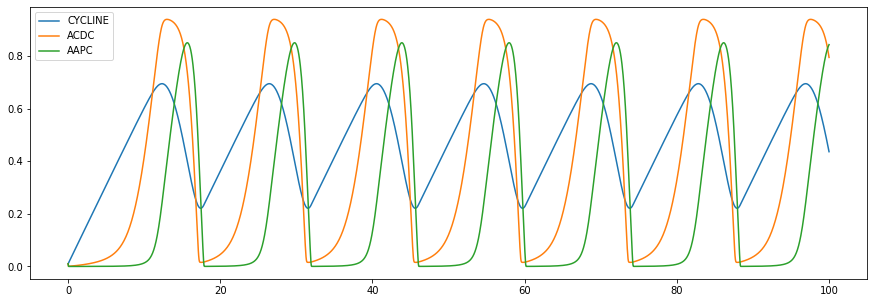

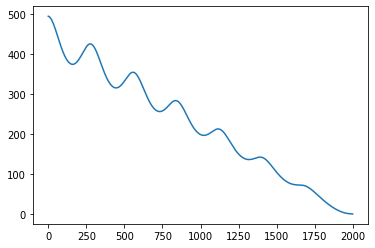

In [81]:
model = Model()
model.load("system.txt")
#model.explain()

for species in model.species:
    print(species.equation)
X0 = [0.01,0.01,0.99,0.01,0.99]

initial = model.simulate(X0,100)
initial.plot(["CYCLINE","ACDC","AAPC"])

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

c = autocorr(initial.solution[:,0])
plt.plot(c)
plt.show()

maxi = argrelextrema(initial.solution[:,0], np.greater)

